In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings 
warnings.filterwarnings('ignore')


In [3]:
# Load the training and test datasets
train_path = '/Users/mansoor/Documents/GSU/Coursework/AML/Project/data/train.csv'
test_path = '/Users/mansoor/Documents/GSU/Coursework/AML/Project/data/test.csv'

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

# Display the first few rows of the dataset to understand the structure
train_data.head()

print("Size of the training data: ", train_data.shape)


Size of the training data:  (177024, 508)


In [4]:
test_data.head()

id p_num      time  bg-5:55  bg-5:50  bg-5:45  bg-5:40  bg-5:35  \
0  p01_8459   p01  06:45:00      NaN      9.2      NaN      NaN     10.2   
1  p01_8460   p01  11:25:00      NaN      NaN      9.9      NaN      NaN   
2  p01_8461   p01  14:45:00      NaN      5.5      NaN      NaN      5.5   
3  p01_8462   p01  04:30:00      NaN      3.4      NaN      NaN      3.9   
4  p01_8463   p01  04:20:00      NaN      NaN      8.3      NaN      NaN   

   bg-5:30  bg-5:25  ...  activity-0:45  activity-0:40  activity-0:35  \
0      NaN      NaN  ...            NaN            NaN            NaN   
1      9.4      NaN  ...            NaN            NaN            NaN   
2      NaN      NaN  ...            NaN            NaN            NaN   
3      NaN      NaN  ...            NaN            NaN            NaN   
4     10.0      NaN  ...            NaN            NaN            NaN   

   activity-0:30  activity-0:25  activity-0:20  activity-0:15  activity-0:10  \
0            NaN            NaN            NaN            NaN            NaN   
1            NaN            NaN            NaN            NaN           Walk   
2            NaN            NaN            NaN            NaN            NaN   
3            NaN            NaN            NaN            NaN            NaN   
4            NaN            NaN            NaN            NaN            NaN   

   activity-0:05  activity-0:00  
0            NaN            NaN  
1           Walk           Walk  
2            NaN            NaN  
3            NaN            NaN  
4            NaN            NaN  

[5 rows x 507 columns]

In [5]:
# Extract the unique feature names by identifying the pattern of the column names
train_columns = train_data.columns

# Use set comprehension to extract unique feature types (such as 'bg', 'insulin', 'carbs', etc.)
unique_features = {col.split('-')[0] for col in train_columns if '-' in col}

# Print the unique feature names
unique_features


{'activity', 'bg', 'cals', 'carbs', 'hr', 'insulin', 'steps'}

In [6]:
print("Training set: ", train_data.shape)
print("Test set: ", test_data.shape)

Training set:  (177024, 508)
Test set:  (3644, 507)


In [7]:
bg_label = train_data.loc[:,"bg+1:00"]
bg_label

0         13.4
1         12.8
2         15.5
3         14.8
4         12.7
          ... 
177019    11.1
177020    10.9
177021    10.7
177022    10.5
177023    10.2
Name: bg+1:00, Length: 177024, dtype: float64

In [8]:
# Check for missing values
print(train_data.isnull().sum())

# Summary statistics of the dataset
print(train_data.describe())

id                    0
p_num                 0
time                  0
bg-5:55           27254
bg-5:50           18491
                  ...  
activity-0:15    174293
activity-0:10    174287
activity-0:05    174271
activity-0:00    174287
bg+1:00               0
Length: 508, dtype: int64
             bg-5:55        bg-5:50        bg-5:45        bg-5:40  \
count  149770.000000  158533.000000  163364.000000  149766.000000   
mean        8.211018       8.230449       8.253291       8.210988   
std         2.852188       2.913438       2.945594       2.852090   
min         2.200000       2.200000       2.200000       2.200000   
25%         6.100000       6.100000       6.100000       6.100000   
50%         7.600000       7.600000       7.700000       7.600000   
75%         9.800000       9.800000       9.800000       9.800000   
max        22.200000      25.100000      27.800000      22.200000   

             bg-5:35        bg-5:30        bg-5:25        bg-5:20  \
count  158254.00000

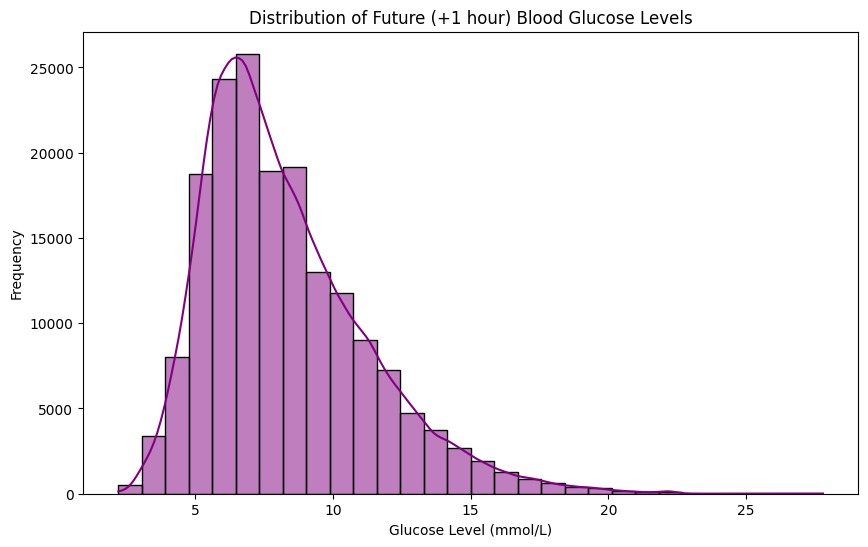

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(train_data['bg+1:00'], kde=True, bins=30, color='purple')
plt.title('Distribution of Future (+1 hour) Blood Glucose Levels')
plt.xlabel('Glucose Level (mmol/L)')
plt.ylabel('Frequency')
plt.show()


['bg-5:00', 'bg-4:00', 'bg-3:00', 'bg-2:00', 'bg-1:00', 'bg-0:00']


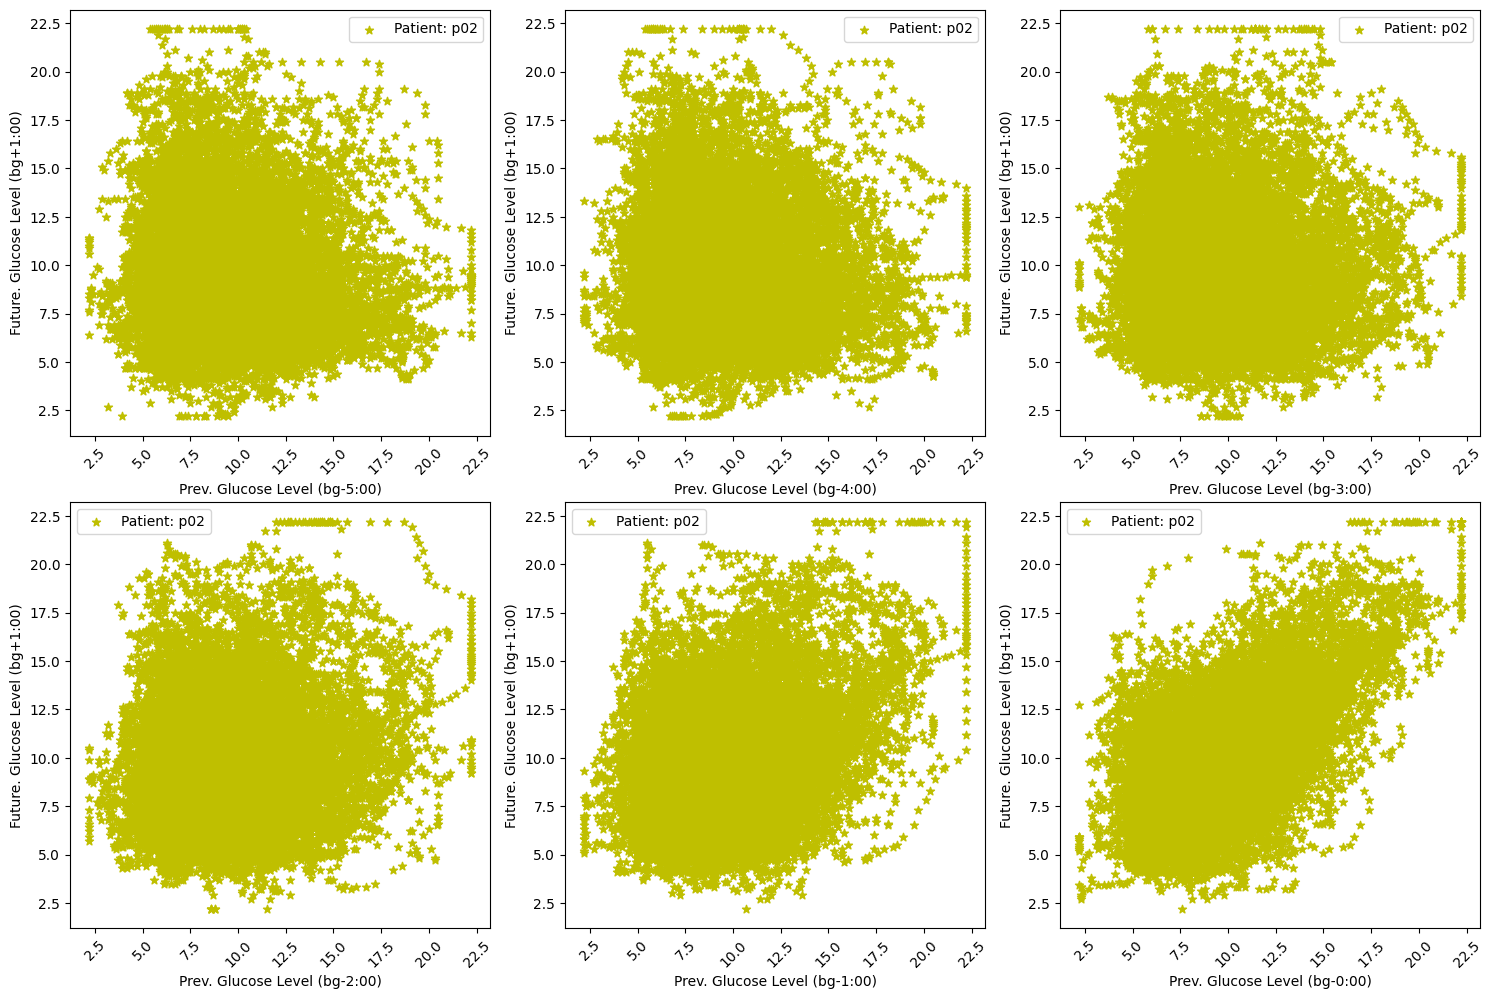

In [10]:
# Randomly select a patient
random_patient = train_data['p_num'].sample(1).values[0]
patient_data = train_data[train_data['p_num'] == random_patient]

# Extract the past 6 hours of glucose levels (divided into per hour)
hours = [f'bg-{i}:00' for i in range(5, -1, -1)]
print(hours)

# Plotting
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, hour in enumerate(hours):
    axes[i].scatter(patient_data[hour], patient_data['bg+1:00'], label=f'Patient: {random_patient}', color='y', marker="*")
    # axes[i].plot(patient_data['time'], patient_data['bg+1:00'], label='bg+1:00', color='red', linestyle='dashed')
    axes[i].set_xlabel(f'Prev. Glucose Level ({hour})')
    axes[i].set_ylabel('Future. Glucose Level (bg+1:00)')
    # axes[i].set_title(f'{hour} vs Future bg+1:00')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].legend()

plt.tight_layout()
plt.show()


In [11]:
# List of feature types (bg, insulin, carbs, etc.)
feature_types = ['bg', 'insulin', 'carbs']

# Create a new DataFrame to store the aggregated features
aggregated_data = pd.DataFrame()

# Loop over each feature type and compute summary statistics for the past 6 hours
for feature in feature_types:
    feature_columns = [col for col in train_data.columns if feature in col]

    # Compute summary statistics for each feature
    aggregated_data[f'{feature}_mean'] = train_data[feature_columns].mean(axis=1)
    aggregated_data[f'{feature}_std'] = train_data[feature_columns].std(axis=1)
    aggregated_data[f'{feature}_max'] = train_data[feature_columns].max(axis=1)
    aggregated_data[f'{feature}_min'] = train_data[feature_columns].min(axis=1)
    aggregated_data[f'{feature}_moving_avg'] = train_data[feature_columns].rolling(window=6, axis=1).mean().mean(axis=1)

# Append the target (future bg+1:00) to the new aggregated DataFrame
aggregated_data['bg+1:00'] = train_data['bg+1:00']

# Display the new aggregated data
print(aggregated_data.head())


/var/folders/kj/vbx4s2zd1v1ff2bc0p2tvy6r0000gn/T/ipykernel_1438/2271395157.py:16: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  aggregated_data[f'{feature}_moving_avg'] = train_data[feature_columns].rolling(window=6, axis=1).mean().mean(axis=1)
/var/folders/kj/vbx4s2zd1v1ff2bc0p2tvy6r0000gn/T/ipykernel_1438/2271395157.py:16: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  aggregated_data[f'{feature}_moving_avg'] = train_data[feature_columns].rolling(window=6, axis=1).mean().mean(axis=1)
/var/folders/kj/vbx4s2zd1v1ff2bc0p2tvy6r0000gn/T/ipykernel_1438/2271395157.py:16: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  aggregated_data[f'{feature}_moving_avg'] = train_data[feature_columns].rolling(window=6, ax

   bg_mean    bg_std  bg_max  bg_min  bg_moving_avg  insulin_mean  \
0   13.344  3.632387    18.4     8.1            NaN      0.025894   
1   13.512  3.555198    18.4     8.1            NaN      0.027286   
2   13.788  3.479143    18.4     8.1            NaN      0.028678   
3   13.944  3.335051    18.4     8.1            NaN      0.030069   
4   14.048  3.164138    18.4     8.1            NaN      0.031461   

   insulin_std  insulin_max  insulin_min  insulin_moving_avg  carbs_mean  \
0     0.023719       0.0583       0.0083            0.025713         NaN   
1     0.023624       0.0583       0.0083            0.027457         NaN   
2     0.023445       0.0583       0.0083            0.028952         NaN   
3     0.023180       0.0583       0.0083            0.030448         NaN   
4     0.022826       0.0583       0.0083            0.031943         NaN   

   carbs_std  carbs_max  carbs_min  carbs_moving_avg  bg+1:00  
0        NaN        NaN        NaN               NaN     13.4  


In [12]:
# Define a function to bin the data into hourly intervals (12 five-minute intervals per hour)
def bin_hourly(data, feature, num_bins=6):
    feature_columns = [col for col in data.columns if feature in col]
    bins = np.array_split(feature_columns, num_bins)  # Split into 6 bins (1 hour each)
    
    binned_data = pd.DataFrame()
    for i, bin_cols in enumerate(bins):
        binned_data[f'{feature}_hour_{i+1}'] = data[bin_cols].mean(axis=1)
    
    return binned_data

# Apply the binning to bg, insulin, and carbs features
bg_binned = bin_hourly(train_data, 'bg')
insulin_binned = bin_hourly(train_data, 'insulin')
carbs_binned = bin_hourly(train_data, 'carbs')

# Concatenate all binned features together with the target
aggregated_data = pd.concat([bg_binned, insulin_binned, carbs_binned, train_data['bg+1:00']], axis=1)

# Display the new binned data
print(aggregated_data.head())


   bg_hour_1  bg_hour_2  bg_hour_3  bg_hour_4  bg_hour_5  bg_hour_6  \
0      9.300      8.600     12.400     15.250     17.975      15.90   
1      9.000      9.275     13.175     16.250     17.800      15.16   
2      8.600     10.200     13.775     17.300     17.525      15.02   
3      8.375     11.325     14.425     17.950     17.075      14.40   
4      8.600     12.400     15.250     17.975     16.525      13.64   

   insulin_hour_1  insulin_hour_2  insulin_hour_3  insulin_hour_4  \
0          0.0083          0.0083        0.008300        0.016633   
1          0.0083          0.0083        0.008300        0.029133   
2          0.0083          0.0083        0.008300        0.041633   
3          0.0083          0.0083        0.008300        0.054133   
4          0.0083          0.0083        0.016633        0.058300   

   insulin_hour_5  insulin_hour_6  carbs_hour_1  carbs_hour_2  carbs_hour_3  \
0        0.058300        0.055533           NaN           NaN           NaN   


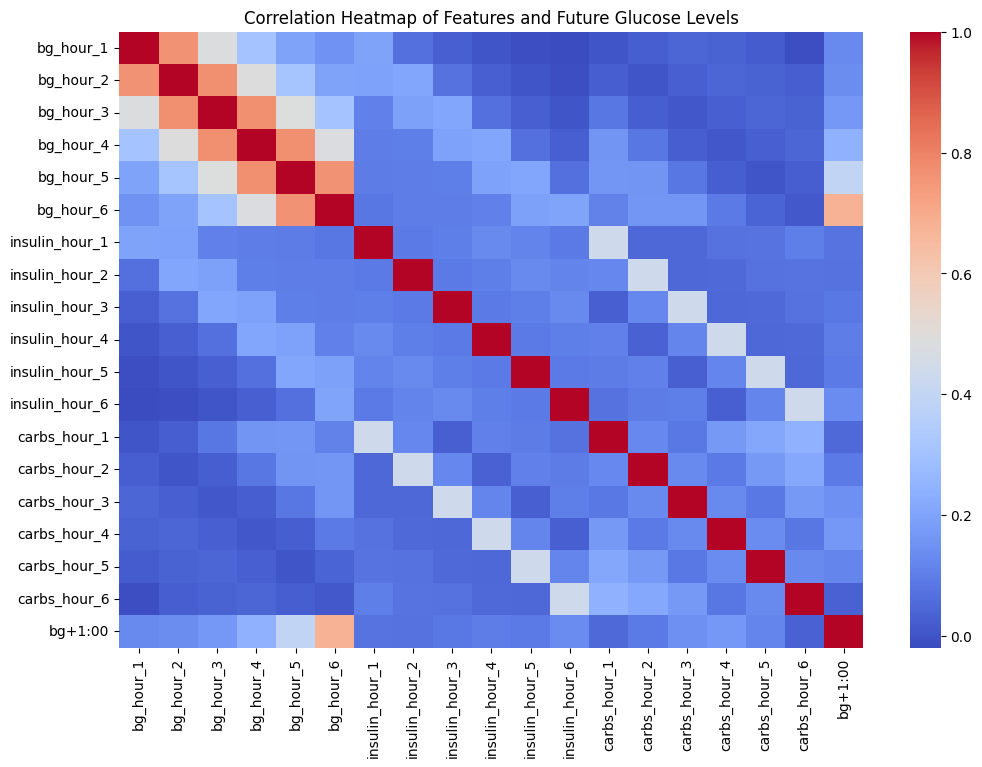

In [13]:
# Extract features related to bg, insulin, carbs, and the target bg+1:00
relevant_columns = [col for col in train_data.columns if 'bg-' in col or 'insulin-' in col or 'carbs-' in col]
relevant_columns.append('bg+1:00')

# Compute the correlation matrix
correlation_matrix = aggregated_data.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap of Features and Future Glucose Levels')
plt.show()


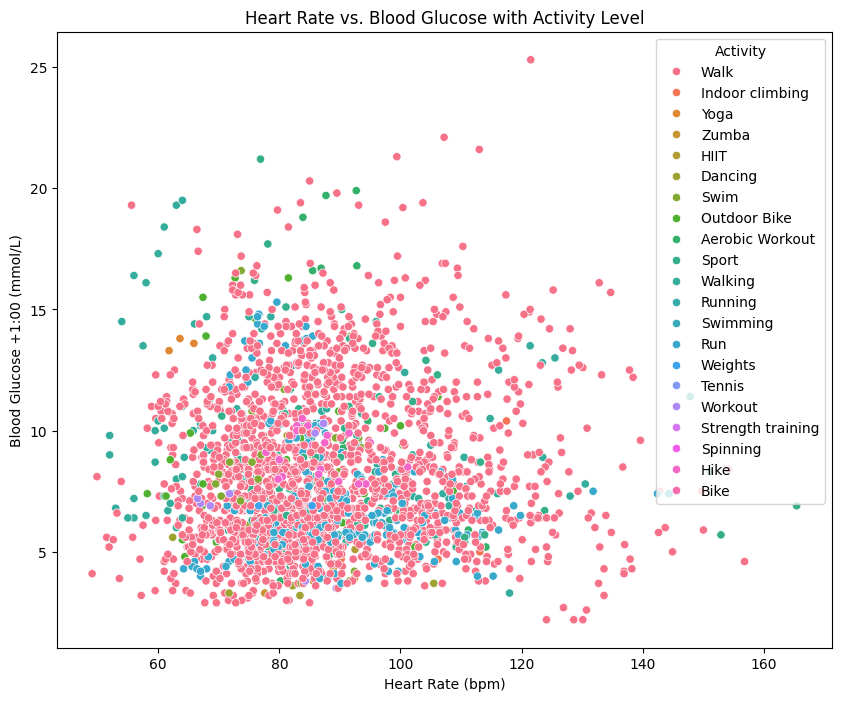

In [14]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x=train_data['hr-1:00'], y=train_data['bg+1:00'], hue=train_data['activity-3:00'])
plt.title('Heart Rate vs. Blood Glucose with Activity Level')
plt.xlabel('Heart Rate (bpm)')
plt.ylabel('Blood Glucose +1:00 (mmol/L)')
plt.legend(title='Activity')
plt.show()


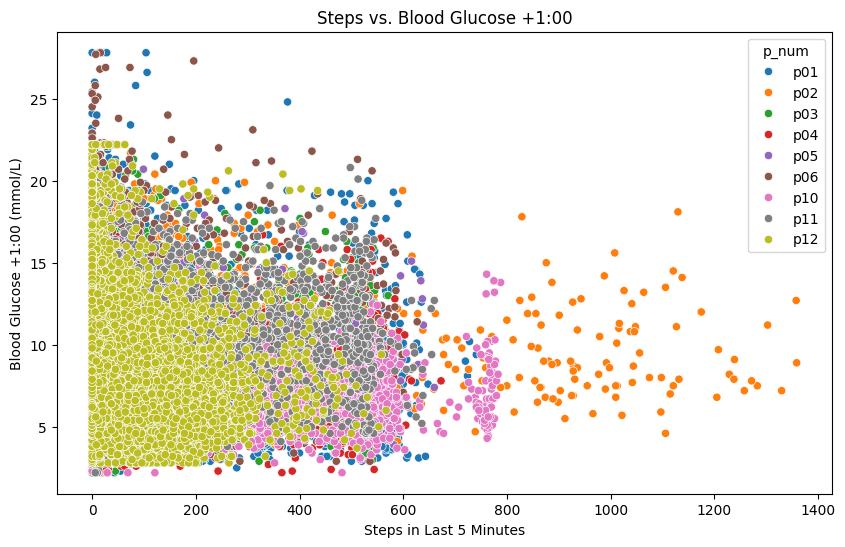

In [15]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=train_data['steps-2:00'], y=train_data['bg+1:00'], hue=train_data['p_num'])
plt.title('Steps vs. Blood Glucose +1:00')
plt.xlabel('Steps in Last 5 Minutes')
plt.ylabel('Blood Glucose +1:00 (mmol/L)')
plt.show()
